In [1]:
!pip install statsforecast

In [2]:
# CELDA 1-- importaciones de bibliotecas y configuracion
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum, to_date, max as spark_max, min as spark_min, expr, when
from pyspark.sql.window import Window
from statsforecast import StatsForecast
from statsforecast.models import (
    Naive, 
    SimpleExponentialSmoothing, 
    Holt, 
    AutoETS,
    WindowAverage,
    RandomWalkWithDrift,
    AutoARIMA
)

# --- PARÁMETROS ---
CONF = {
    "test_weeks": 12,       # Semanas para validar (Backtesting)
    "horizon": 12,          # Semanas a predecir a futuro (Producción)
    "zero_threshold": 0.50, # Filtro de ceros (opcional, si lo usas)
    "cv_threshold": 10,     # Filtro de coeficiente de variación
    "min_accuracy": 60.0,   # Umbral para decidir si el modelo es útil
    "upper_quantile": 0.80, # Límite para winsorización (outliers)
    "input_path": "Files/ventas_categorizadas_24_25.csv",
    "output_path_report": "Tables/historico_predicciones_nixtla", 
    "output_path_graphs": "/lakehouse/default/Files/graphs",
    "report_save_mode": 'overwrite'
}

print("Configuración cargada.")

Configuración cargada.


In [ ]:
# CELDA 3: convertir a pandas, dividir para la cross validation
# 1. Convertir a Pandas
Y_df = df_full.toPandas()
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# 2. Ordenar datos
Y_df = Y_df.sort_values(['unique_id', 'ds'])

# 3. Definir punto de corte para validación
# Todo lo anterior a esto es para entrenar, todo lo posterior es para evaluar
cutoff_date = Y_df['ds'].max() - pd.Timedelta(weeks=CONF['test_weeks'])
print(f"Fecha de corte para Train/Test: {cutoff_date}")

# 4. Separación ESTRICTA
# Train: Lo que usaremos para aprender (y limpiar)
Y_train = Y_df[Y_df['ds'] <= cutoff_date].copy()

# Test Real: La verdad absoluta (con ruido y picos reales) contra la que nos evaluaremos
Y_test_real = Y_df[Y_df['ds'] > cutoff_date].copy()

print(f"Registros en Train: {len(Y_train)}")
print(f"Registros en Test (Real): {len(Y_test_real)}")

StatementMeta(, 5cdca575-ca7a-47cb-a9ec-5aac6c3da5fc, 22, Finished, Available, Finished)

Fecha de corte para Train/Test: 2025-08-04 00:00:00
Registros en Train: 336
Registros en Test (Real): 46


In [ ]:
# CELDA 4: Windzorizado del set de entrenamiento
def winsorize_train_data(group, upper_quantile=CONF['upper_quantile']):
    """
    Calcula límites basados SOLO en el set de entrenamiento para evitar ver el futuro.
    """
    # Calculamos el límite superior
    upper_limit = group['y'].quantile(upper_quantile)
    
    # Aplicamos limpieza (Clipping)
    # Si la venta es > al limite, se recorta.
    group['y'] = group['y'].clip(lower=0, upper=upper_limit)
    
    return group

print("Aplicando Winsorización SOLAMENTE al set de entrenamiento...")

# Aplicamos la limpieza y creamos un nuevo DF limpio para entrenar
Y_train_clean = Y_train.groupby('unique_id').apply(winsorize_train_data).reset_index(drop=True)

print("Limpieza completada en Train.")

StatementMeta(, 5cdca575-ca7a-47cb-a9ec-5aac6c3da5fc, 23, Finished, Available, Finished)

Aplicando Winsorización SOLAMENTE al set de entrenamiento...
Limpieza completada en Train.


In [ ]:
#CELDA 5: Entrenamiento de modelos, prediccion con modelos entrenados
# 1. Definir Modelos
ventanas_a_probar = [2, 3, 4, 6, 8]

models = [
    Naive(),
    AutoETS(model='ZZN', season_length=1, alias='Auto_Smoothing'),
    *[WindowAverage(window_size=w, alias=f"MovAvg_{w}") for w in ventanas_a_probar],
    RandomWalkWithDrift(),
    AutoARIMA()
]

# 2. Instanciar StatsForecast
sf = StatsForecast(
    models=models, 
    freq='W-MON', 
    n_jobs=-1
)

# 3. Entrenar (Fit) solo con Train Limpio
print("Entrenando modelos...")
sf.fit(df=Y_train_clean)

# 4. Predecir (Forecast) hacia el horizonte de prueba
# Esto generará predicciones para las semanas que están en Y_test_real
Y_hat = sf.predict(h=CONF['test_weeks'])
Y_hat = Y_hat.reset_index()
display(Y_hat)
print("Predicciones de validación generadas.")

StatementMeta(, 5cdca575-ca7a-47cb-a9ec-5aac6c3da5fc, 24, Finished, Available, Finished)

Entrenando modelos...


2025-12-16:02:05:08,690 ERROR    [synapse_mlflow_utils.py:333] An error occurred while calling None.None. Trace:
java.lang.ClassNotFoundException: org.apache.spark.sql.SparkSession$getActiveSession
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:476)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:594)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:527)
	at java.base/java.lang.Class.forName0(Native Method)
	at java.base/java.lang.Class.forName(Class.java:398)
	at py4j.reflection.CurrentThreadClassLoadingStrategy.classForName(CurrentThreadClassLoadingStrategy.java:40)
	at py4j.reflection.ReflectionUtil.classForName(ReflectionUtil.java:51)
	at py4j.reflection.ReflectionEngine.getConstructor(ReflectionEngine.java:191)
	at py4j.Gateway.invoke(Gateway.java:237)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.GatewayConnection

SynapseWidget(Synapse.DataFrame, 5330bcc3-0ba9-4301-a58b-497eb70bbbdf)

Predicciones de validación generadas.


In [ ]:
# CELDA 6: Generacion de Reporte Final (Evaluacion + Proyeccion)

# --- 1. EVALUACION (BACKTESTING) ---
# Calcular estadisticas del Test Set Real (Media y Varianza)
real_stats = Y_test_real.groupby('unique_id')['y'].agg(['mean', 'var']).reset_index()
real_stats.columns = ['SKU', 'media_real', 'varianza_real']

# Unir predicciones con datos reales para calcular error
eval_df = Y_test_real.merge(Y_hat, on=['unique_id', 'ds'], how='left')

# Identificar columnas de modelos (Excluyendo metadatos y posible basura como 'index')
model_cols = [c for c in eval_df.columns if c not in ['unique_id', 'ds', 'y', 'index']]

# Calcular MAE para CADA modelo y SKU
mae_results = []
for model in model_cols:
    # Clipping a 0 para evitar negativos
    eval_df[model] = eval_df[model].clip(lower=0)
    # Error absoluto medio
    mae = eval_df.groupby('unique_id').apply(lambda x: np.mean(np.abs(x['y'] - x[model]))).reset_index()
    mae.columns = ['SKU', 'MAE']
    mae['modelo'] = model
    mae_results.append(mae)

metrics_df = pd.concat(mae_results)

# Unir metricas con estadisticas reales
report = metrics_df.merge(real_stats, on='SKU')

# Calcular Accuracy y Decision
# Accuracy = 1 - (MAE / Media)
report['accuracy'] = np.where(
    report['media_real'] > 0,
    1 - (report['MAE'] / report['media_real']),
    0.0
)

# Decision basada en el umbral (convertimos accuracy a % para comparar con CONF)
report['desicion'] = np.where(
    (report['accuracy'] * 100) >= CONF["min_accuracy"], 
    "PREDECIR", 
    "NO_PREDECIR"
)

# --- 2. PROYECCION FUTURA (RE-ENTRENAMIENTO) ---
print("Re-entrenando modelos con historia completa...")

# Limpieza del dataset completo
Y_full_clean = Y_df.groupby('unique_id').apply(winsorize_train_data).reset_index(drop=True)

# Entrenar con TODO el historial
sf.fit(df=Y_full_clean)

# Predecir 14 semanas a futuro
horizonte_futuro = 14
Y_future = sf.predict(h=horizonte_futuro).reset_index()

# Limpieza preventiva: Eliminar columna 'index' si se genero
if 'index' in Y_future.columns:
    Y_future = Y_future.drop(columns=['index'])

# Transformar predicciones a formato ancho (Columnas sem_1, sem_2...)
# 1. Melt para tener formato largo: SKU | Fecha | Modelo | Valor
future_melt = Y_future.melt(
    id_vars=['unique_id', 'ds'],
    value_vars=model_cols, # Solo usamos los modelos validos identificados antes
    var_name='modelo',
    value_name='prediccion'
)

# 2. Ordenar y asignar numero de semana
future_melt = future_melt.sort_values(['unique_id', 'modelo', 'ds'])
future_melt['week_num'] = future_melt.groupby(['unique_id', 'modelo']).cumcount() + 1
future_melt['col_name'] = "pred_sem_" + future_melt['week_num'].astype(str)

# 3. Pivotar para tener semanas como columnas
future_pivoted = future_melt.pivot_table(
    index=['unique_id', 'modelo'],
    columns='col_name',
    values='prediccion'
).reset_index()

# Renombrar unique_id a SKU para cruzar
future_pivoted.rename(columns={'unique_id': 'SKU'}, inplace=True)

# --- 3. CONSOLIDACION DEL REPORTE ---
final_df = report.merge(future_pivoted, on=['SKU', 'modelo'], how='left')

# Definir orden de columnas de semanas
sem_cols = [f"pred_sem_{i}" for i in range(1, horizonte_futuro + 1)]

# Aplicar logica de negocio: Si NO_PREDECIR -> Llenar con media_real
for col in sem_cols:
    final_df[col] = np.where(
        final_df['desicion'] == 'PREDECIR',
        final_df[col].clip(lower=0), # Prediccion del modelo (sin negativos)
        final_df['media_real']       # Fallback a media
    )

# Seleccion y orden final de columnas
final_cols = ['SKU', 'media_real', 'varianza_real', 'modelo', 'accuracy', 'desicion'] + sem_cols
final_report = final_df[final_cols].copy()

print("Reporte final generado exitosamente.")
display(final_report)

# Opcional: Guardar a CSV para descargar
# final_report.to_csv("reporte_final_v2_fixed.csv", index=False)

StatementMeta(, 5cdca575-ca7a-47cb-a9ec-5aac6c3da5fc, 26, Finished, Available, Finished)

Re-entrenando modelos con historia completa...


2025-12-16:02:17:33,623 ERROR    [synapse_mlflow_utils.py:333] 'NoneType' object has no attribute '_1'
Traceback (most recent call last):
  File "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/synapse/ml/mlflow/synapse_mlflow_utils.py", line 330, in set_envs
    config = MLConfig(sc)
             ^^^^^^^^^^^^
  File "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/synapse/ml/mlflow/synapse_mlflow_utils.py", line 134, in __init__
    self.env_configs = self.get_mlflow_configs()
                       ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/synapse/ml/mlflow/synapse_mlflow_utils.py", line 164, in get_mlflow_configs
    region = self._get_spark_config("spark.cluster.region")
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/synapse/ml/mlflow/synapse_mlflow

Reporte final generado exitosamente.


SynapseWidget(Synapse.DataFrame, 450b11dd-dbcd-4dfb-9616-7fe821ff2443)

StatementMeta(, 5cdca575-ca7a-47cb-a9ec-5aac6c3da5fc, 27, Finished, Available, Finished)

Generando graficas para 4 SKUs...


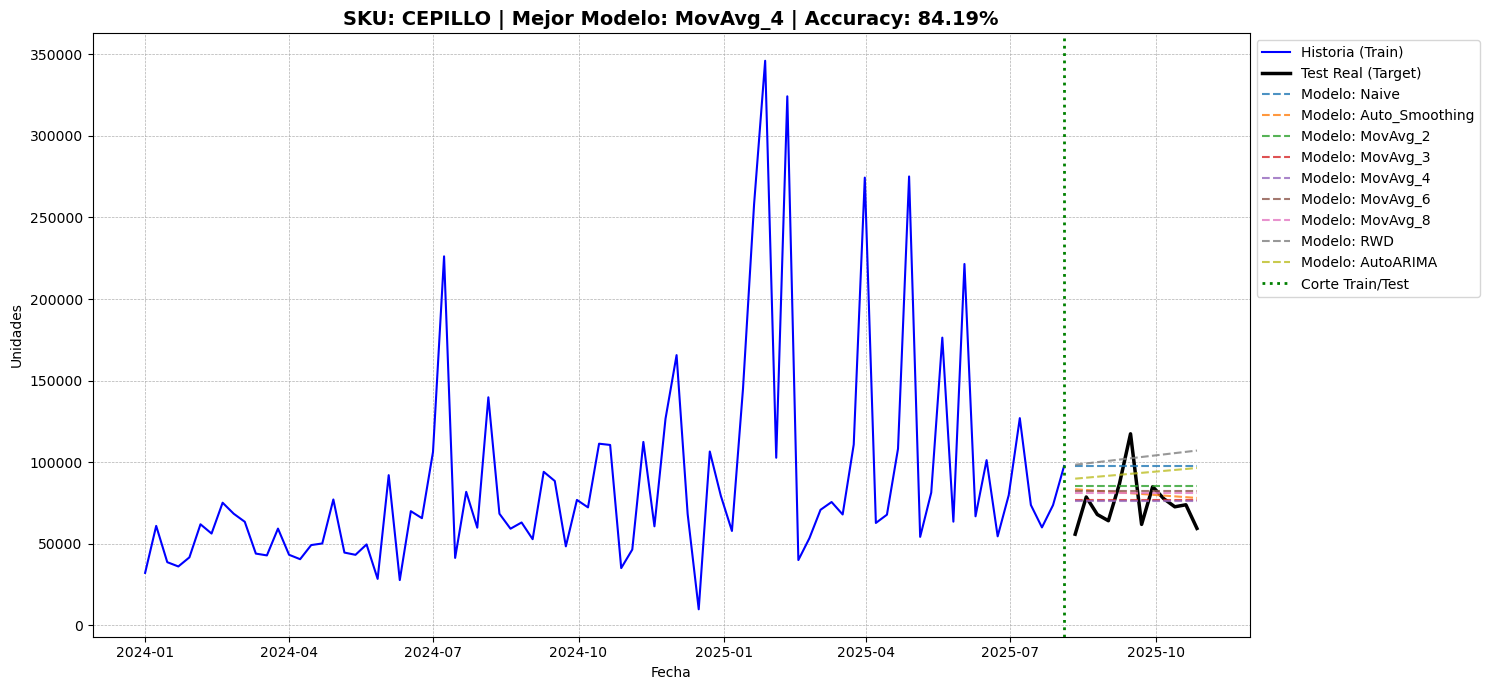

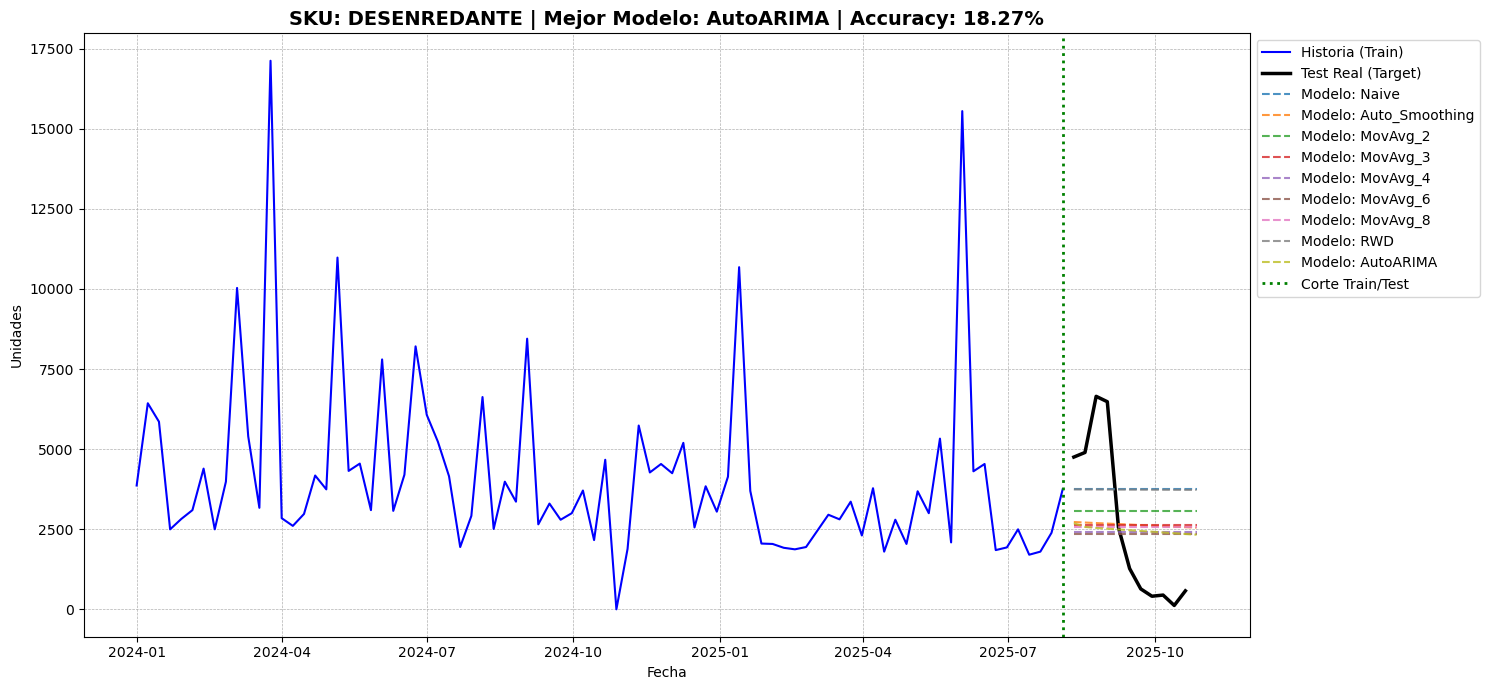

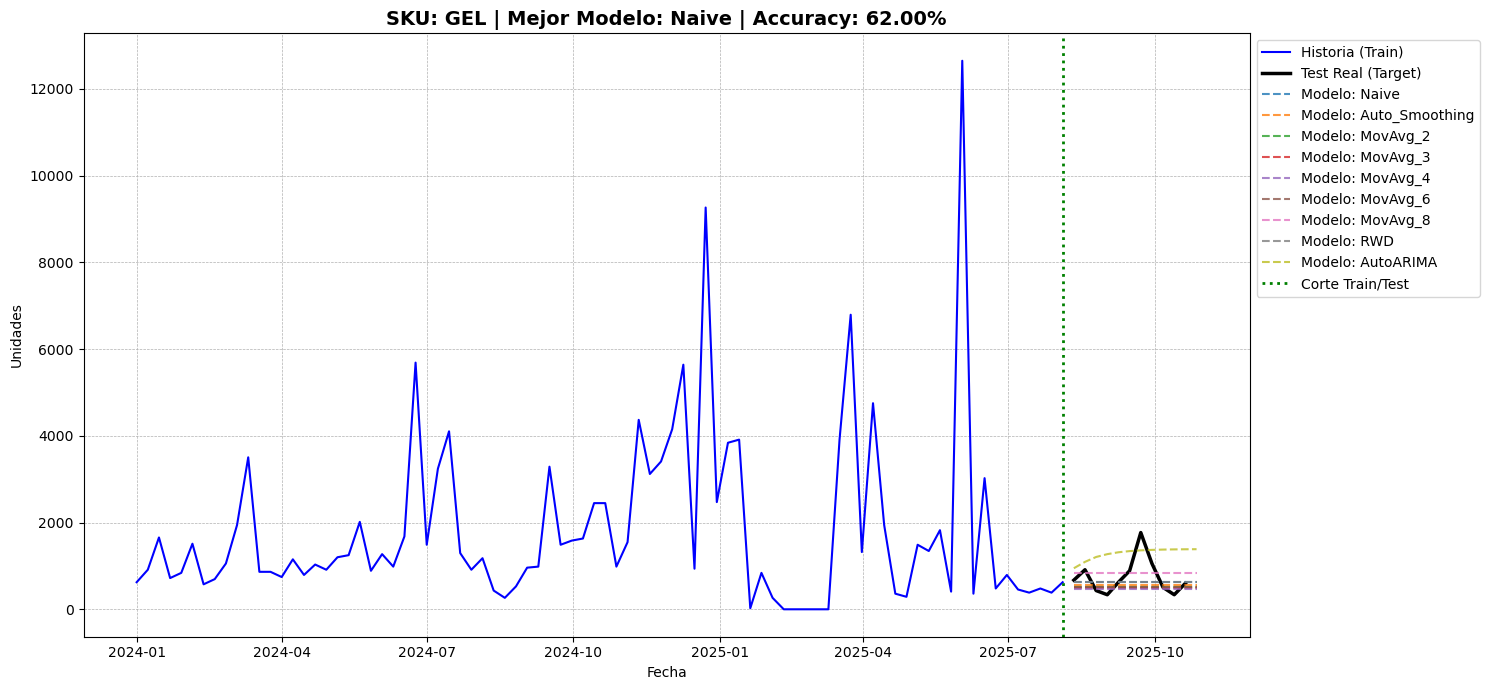

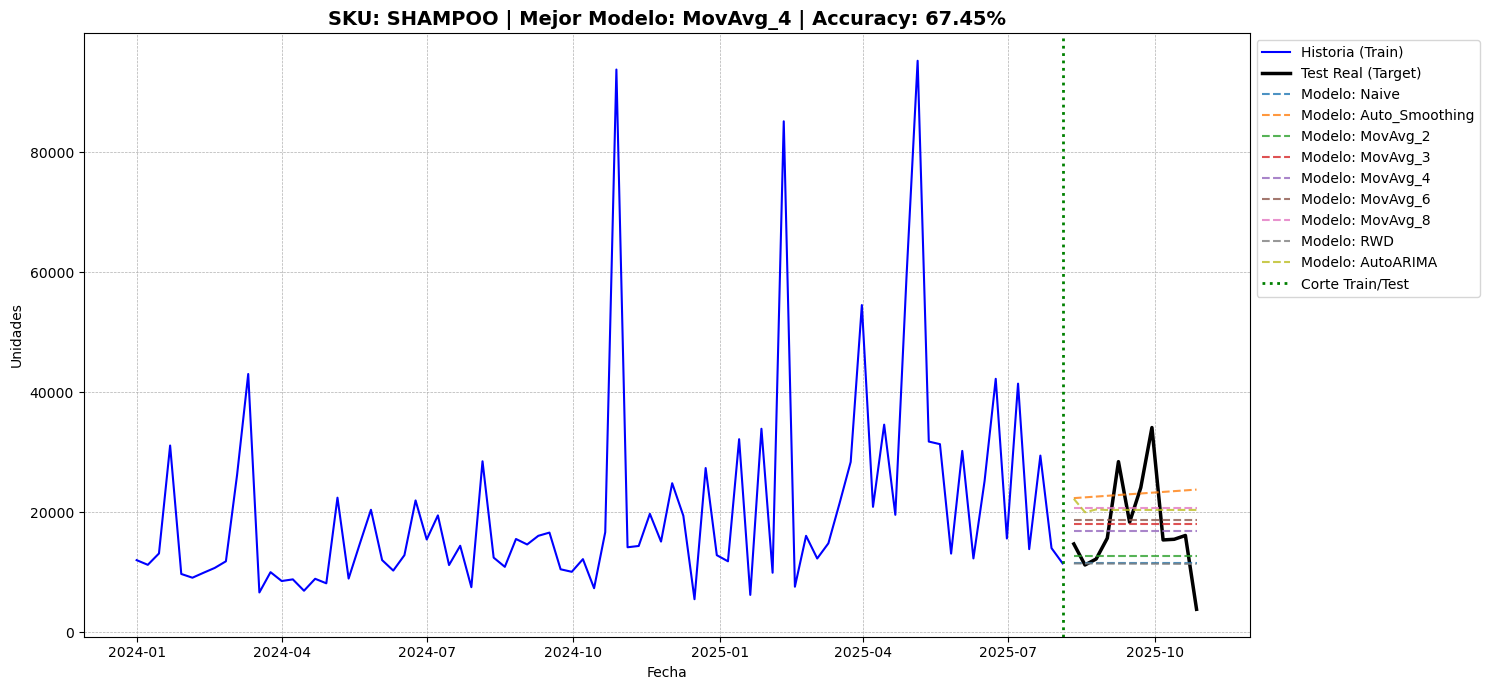

In [ ]:
# CELDA 7: Generacion de Graficas de Evaluacion (Historia + Test vs Modelos)

import matplotlib.pyplot as plt

# Obtener lista de SKUs unicos presentes en el reporte
skus_a_graficar = final_report['SKU'].unique()

print(f"Generando graficas para {len(skus_a_graficar)} SKUs...")

for sku in skus_a_graficar:
    plt.figure(figsize=(15, 7))
    
    # --- 1. Historia (Train) en AZUL ---
    # Filtramos los datos de entrenamiento para este SKU
    train_sku = Y_train[Y_train['unique_id'] == sku]
    plt.plot(train_sku['ds'], train_sku['y'], label='Historia (Train)', color='blue')
    
    # --- 2. Test Set Real (Objetivo) en NEGRO ---
    # Filtramos los datos reales de prueba
    test_real_sku = Y_test_real[Y_test_real['unique_id'] == sku]
    plt.plot(test_real_sku['ds'], test_real_sku['y'], label='Test Real (Target)', color='black', linewidth=2.5)
    
    # --- 3. Predicciones de CADA modelo en el Test Set (Punteadas) ---
    # Filtramos las predicciones (Y_hat) generadas en la Celda 5
    preds_sku = Y_hat[Y_hat['unique_id'] == sku]
    
    # Identificamos las columnas de los modelos (todas menos IDs y fechas)
    model_cols = [c for c in preds_sku.columns if c not in ['unique_id', 'ds', 'y', 'index']]
    
    # Ploteamos cada modelo con un ciclo de colores automatico pero estilo punteado
    for model in model_cols:
        plt.plot(preds_sku['ds'], preds_sku[model], linestyle='--', alpha=0.8, label=f'Modelo: {model}')
        
    # --- 4. Titulo Dinamico (Mejor Modelo y Accuracy) ---
    # Buscamos en el reporte final cual fue el mejor para este SKU especifico
    report_sku = final_report[final_report['SKU'] == sku]
    
    # Encontramos la fila con la maxima accuracy
    best_row = report_sku.loc[report_sku['accuracy'].idxmax()]
    best_model_name = best_row['modelo']
    best_acc = best_row['accuracy'] * 100 # Convertir a porcentaje para visualizacion
    
    # Detalles visuales
    plt.axvline(x=cutoff_date, color='green', linestyle=':', linewidth=2, label='Corte Train/Test')
    
    plt.title(f"SKU: {sku} | Mejor Modelo: {best_model_name} | Accuracy: {best_acc:.2f}%", fontsize=14, fontweight='bold')
    plt.xlabel("Fecha")
    plt.ylabel("Unidades")
    
    # Leyenda fuera de la grafica para no tapar los datos si hay muchos modelos
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

StatementMeta(, 5cdca575-ca7a-47cb-a9ec-5aac6c3da5fc, 28, Finished, Available, Finished)

Generando vistas detalladas (Zoom) para 4 SKUs...


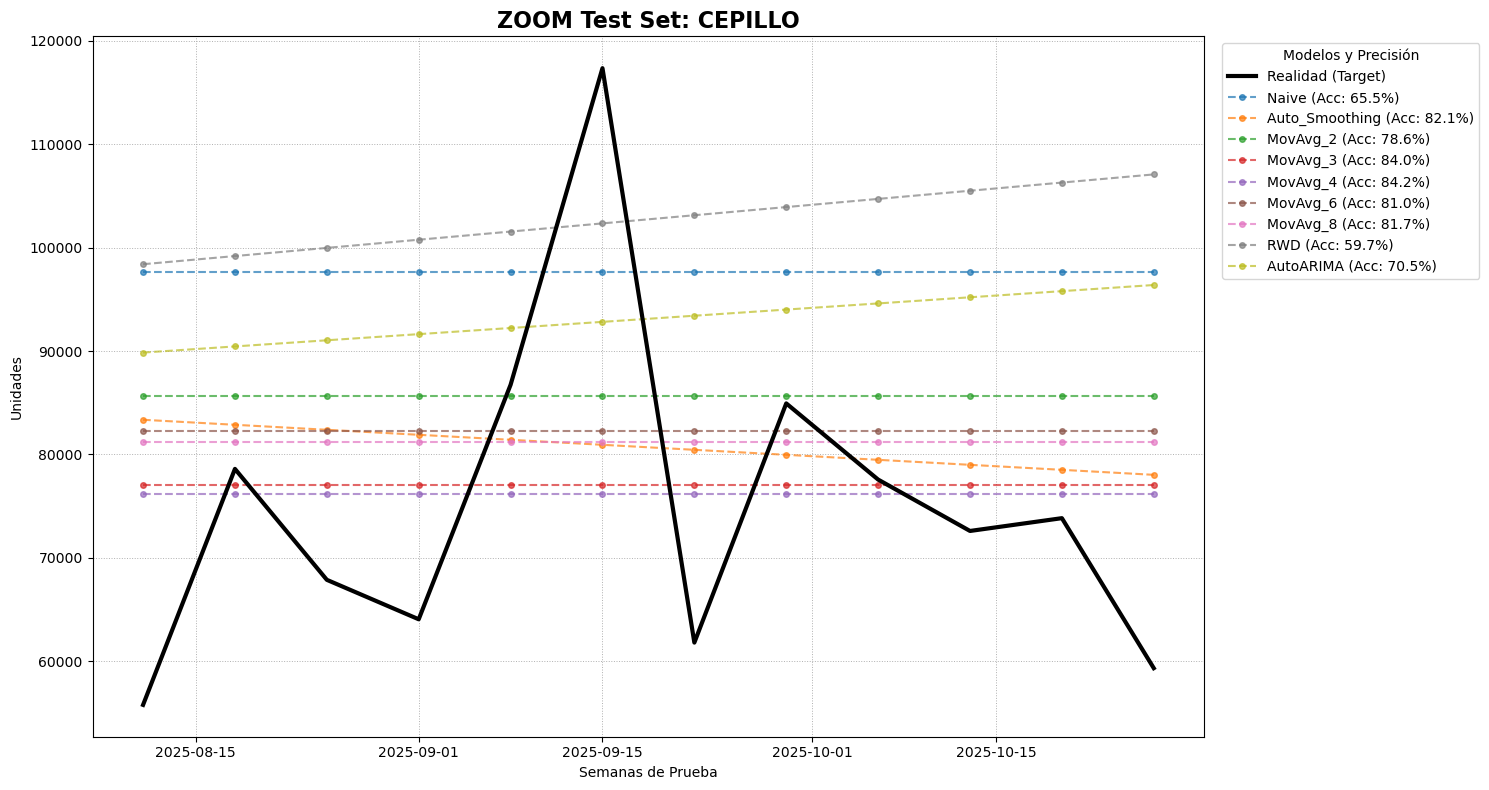

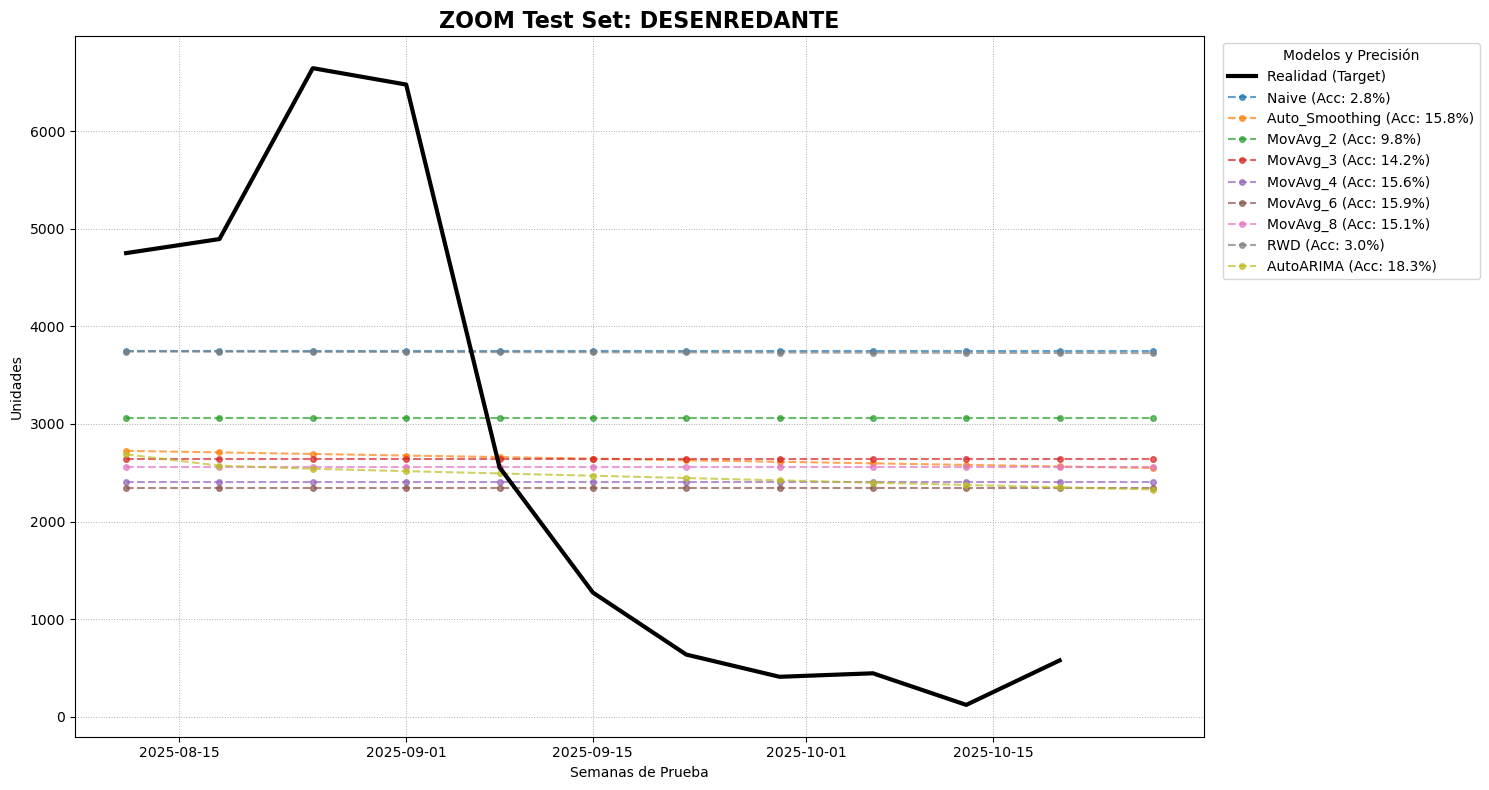

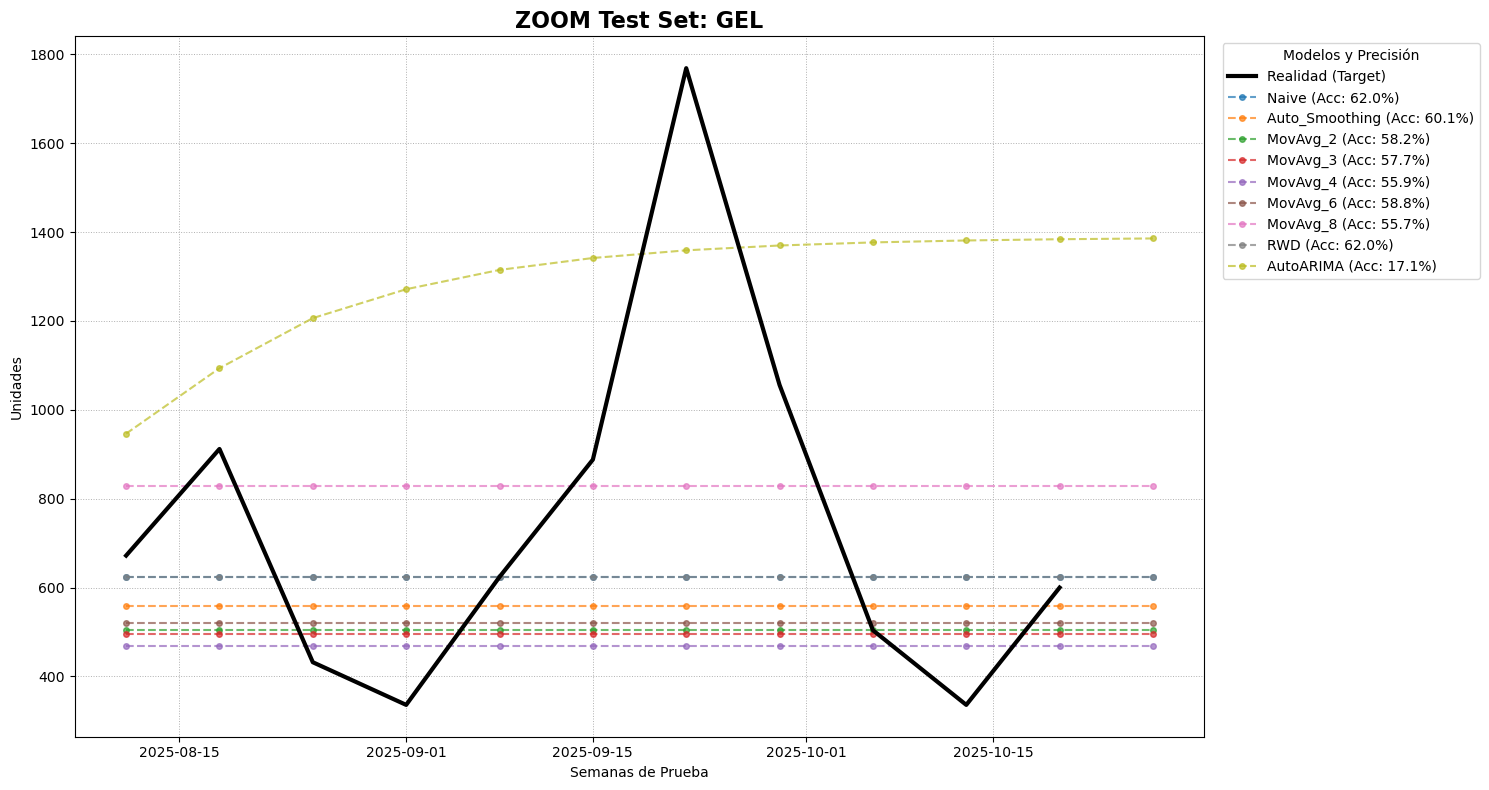

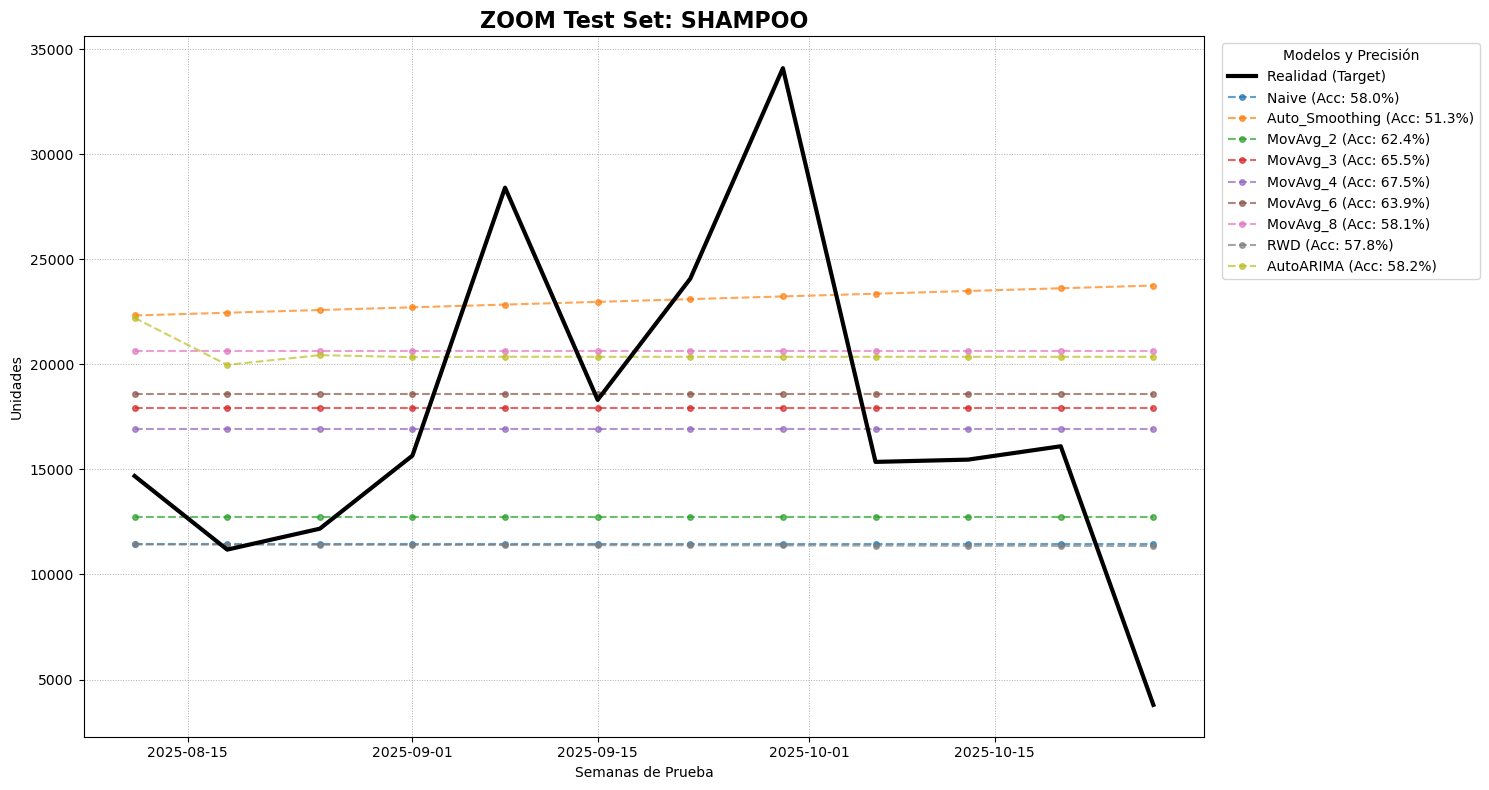

In [ ]:
# CELDA 8: Zoom Detallado en Test Set (Comparativa de Modelos y Accuracy)

# --- 1. Calcular Accuracy para TODOS los modelos (no solo el ganador) ---
# Usamos las metricas calculadas previamente en la celda 6 (metrics_df) y estadisticas reales (real_stats)
all_models_acc = metrics_df.merge(real_stats, on='SKU')

# Calculo de Accuracy por modelo individual
all_models_acc['accuracy_pct'] = np.where(
    all_models_acc['media_real'] > 0,
    (1 - (all_models_acc['MAE'] / all_models_acc['media_real'])) * 100,
    0.0
)

# --- 2. Generar Graficos de Zoom ---
print(f"Generando vistas detalladas (Zoom) para {len(skus_a_graficar)} SKUs...")

for sku in skus_a_graficar:
    plt.figure(figsize=(15, 8))
    
    # A) Datos Reales del Test Set (La verdad absoluta) - Linea gruesa negra
    test_sku = Y_test_real[Y_test_real['unique_id'] == sku]
    plt.plot(test_sku['ds'], test_sku['y'], label='Realidad (Target)', color='black', linewidth=3, zorder=10)
    
    # B) Predicciones de CADA modelo (Backtesting) - Lineas punteadas
    preds_sku = Y_hat[Y_hat['unique_id'] == sku]
    
    # Identificar modelos (excluyendo columnas de sistema)
    model_cols = [c for c in preds_sku.columns if c not in ['unique_id', 'ds', 'y', 'index']]
    
    # Iterar sobre cada modelo para plotear y etiquetar
    for model in model_cols:
        # Buscar el accuracy especifico de ESTE modelo para ESTE sku
        acc_val = all_models_acc.loc[
            (all_models_acc['SKU'] == sku) & (all_models_acc['modelo'] == model), 
            'accuracy_pct'
        ].values[0]
        
        # Plotear con etiqueta enriquecida
        plt.plot(
            preds_sku['ds'], 
            preds_sku[model], 
            linestyle='--', 
            marker='o', # Agregamos puntos para ver mejor los cortes semanales
            markersize=4,
            alpha=0.7, 
            label=f'{model} (Acc: {acc_val:.1f}%)'
        )
    
    # Detalles visuales
    plt.title(f"ZOOM Test Set: {sku}", fontsize=16, fontweight='bold')
    plt.xlabel("Semanas de Prueba")
    plt.ylabel("Unidades")
    
    # Leyenda fuera del grafico para facilitar la lectura
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title="Modelos y Precisión")
    
    plt.grid(True, which='both', linestyle=':', linewidth=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
# CELDA 9: Orquestacion de Guardado (Persistencia en OneLake)

# --- 0. PREPARACION DE VARIABLES ---
# Definimos el snapshot como la fecha maxima encontrada en los datos originales
snapshot_date = pd.to_datetime(Y_df['ds'].max()).strftime('%Y-%m-%d')

# Recuperamos el modo de guardado
save_mode = CONF.get("report_save_mode", "ignore").lower()
table_path = CONF["output_path_report"] # Ej: Tables/historico_predicciones_nixtla

print(f"=== INICIANDO PROCESO DE GUARDADO ===")
print(f"ID de Ejecución (Snapshot Date): {snapshot_date}")
print(f"Modo de operación: {save_mode.upper()}")
print(f"Ruta de destino: {table_path}")

# ==============================================================================
# 1. PERSISTENCIA DE DATOS (Delta Table del Reporte Final)
# ==============================================================================

if save_mode in ["overwrite", "merge"]:
    print(f"\n[DATOS] Procesando tabla Delta...")
    
    # A) Preparar el DataFrame para Spark
    report_to_save = final_report.copy()
    # Convertimos a string o timestamp segun prefieras, string es mas seguro para particionar si fuera necesario
    report_to_save['snapshot_date'] = pd.to_datetime(snapshot_date)
    
    # Limpieza de nombres de columnas para evitar caracteres prohibidos en Delta
    # (Por si acaso algun nombre de modelo tiene caracteres raros)
    report_spark = spark.createDataFrame(report_to_save)
    
    # B) Ejecutar logica de guardado
    if save_mode == "overwrite":
        print("-> Modo OVERWRITE: Sobrescribiendo tabla completa.")
        # option("overwriteSchema", "true") permite cambiar tipos de datos si cambian en el futuro
        report_spark.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save(table_path)
        print("-> Tabla guardada exitosamente.")
        
    elif save_mode == "merge":
        print("-> Modo MERGE: Intentando actualizar/insertar.")
        
        # Verificamos si es una tabla Delta valida
        if DeltaTable.isDeltaTable(spark, table_path):
            deltaTable = DeltaTable.forPath(spark, table_path)
            
            # Condicion de llave primaria compuesta
            # Asegúrate que los nombres de columnas coincidan exactamente con tu DF
            merge_condition = (
                "old.snapshot_date = new.snapshot_date AND " +
                "old.SKU = new.SKU AND " +
                "old.modelo = new.modelo"
            )
            
            # Ejecucion del Merge
            deltaTable.alias("old").merge(
                report_spark.alias("new"),
                merge_condition
            ).whenMatchedUpdateAll() \
             .whenNotMatchedInsertAll() \
             .execute()
            print("-> Merge (Upsert) completado.")
        else:
            print("-> La tabla no existe o no es Delta. Creandola por primera vez...")
            report_spark.write.format("delta").mode("overwrite").save(table_path)
            print("-> Tabla creada.")

else:
    print(f"\n[DATOS] Omitiendo guardado de tabla (Mode: {save_mode})")

# ==============================================================================
# 2. PERSISTENCIA DE ACTIVOS VISUALES (Graficas)
# ==============================================================================

graphs_daily_path = f"{CONF['output_path_graphs']}/{snapshot_date}"

# Crear directorio si no existe
if not os.path.exists(graphs_daily_path):
    os.makedirs(graphs_daily_path, exist_ok=True)

print(f"\n[GRAFICAS] Guardando en: {graphs_daily_path}")

try:
    for sku in skus_a_graficar:
        
        # --- PREPARACION DATOS ---
        train_sku = Y_train[Y_train['unique_id'] == sku]
        test_sku = Y_test_real[Y_test_real['unique_id'] == sku]
        preds_sku = Y_hat[Y_hat['unique_id'] == sku]
        model_cols = [c for c in preds_sku.columns if c not in ['unique_id', 'ds', 'y', 'index']]
        
        # --- A) GRAFICA PANORAMA ---
        plt.figure(figsize=(15, 7))
        plt.plot(train_sku['ds'], train_sku['y'], label='Historia', color='blue')
        plt.plot(test_sku['ds'], test_sku['y'], label='Realidad', color='black', linewidth=2)
        
        for m in model_cols:
            plt.plot(preds_sku['ds'], preds_sku[m], linestyle='--', alpha=0.5, label=m)
            
        plt.title(f"PANORAMA: {sku} (Snapshot: {snapshot_date})")
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.savefig(f"{graphs_daily_path}/PANORAMA_{sku}.png")
        plt.close() 
        
        # --- B) GRAFICA ZOOM ---
        plt.figure(figsize=(15, 7))
        plt.plot(test_sku['ds'], test_sku['y'], label='Realidad', color='black', linewidth=3)
        
        for m in model_cols:
            try:
                acc = all_models_acc.loc[
                    (all_models_acc['SKU'] == sku) & (all_models_acc['modelo'] == m), 
                    'accuracy_pct'
                ].values[0]
                label_txt = f"{m} ({acc:.1f}%)"
            except:
                label_txt = m
                
            plt.plot(preds_sku['ds'], preds_sku[m], linestyle='--', marker='o', label=label_txt)
            
        plt.title(f"ZOOM: {sku}")
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.tight_layout()
        plt.savefig(f"{graphs_daily_path}/ZOOM_{sku}.png")
        plt.close()

    print(f"-> Graficas guardadas para {len(skus_a_graficar)} SKUs.")

except Exception as e:
    print(f"Error generando graficas: {str(e)}")

print("=== PROCESO FINALIZADO ===")

StatementMeta(, 5cdca575-ca7a-47cb-a9ec-5aac6c3da5fc, 33, Finished, Available, Finished)

=== INICIANDO PROCESO DE GUARDADO ===
ID de Ejecución (Snapshot Date): 2025-10-27
Modo de operación: OVERWRITE
Ruta de destino: Tables/historico_predicciones_nixtla

[DATOS] Procesando tabla Delta...
-> Modo OVERWRITE: Sobrescribiendo tabla completa.
-> Tabla guardada exitosamente.

[GRAFICAS] Guardando en: /lakehouse/default/Files/graphs/2025-10-27
-> Graficas guardadas para 4 SKUs.
=== PROCESO FINALIZADO ===
